In [4]:
!pip install numpy matplotlib
!pip install scipy

import data_generator

In [5]:

import numpy as np
import scipy.ndimage

class DEMSimulator:
    def __init__(self, num_dems, size, hilliness_range=(1, 10), total_iterations=10, river_freq=2):
        """
        Initialize the DEM simulator with parameters for DEM generation, smoothing, and river carving.
        
        Args:
        num_dems (int): Number of DEMs to generate.
        size (int): Dimension of the DEMs (n x n).
        hilliness_range (tuple): Range of hilliness factors (min, max).
        total_iterations (int): Total number of iterations (smoothing + river carving).
        river_freq (int): Frequency of river carving steps (every 'river_freq' iterations).
        """
        self.num_dems = num_dems
        self.size = size
        self.hilliness_range = hilliness_range
        self.total_iterations = total_iterations
        self.river_freq = river_freq
        self.dems = []

    def generate_dem(self):
        """
        Generates an evolving DEM by introducing spatially continuous elevation changes over time,
        with a probability-based choice of smoothing, light smoothing, or river carving.
        """
        hilliness = np.random.uniform(*self.hilliness_range)

        # Step 1: Start with a smooth base elevation
        dem = np.random.normal(50, hilliness * 5, (self.size, self.size))
        dem = scipy.ndimage.gaussian_filter(dem, sigma=hilliness / 2)
        dem = (dem - dem.min()) / (dem.max() - dem.min()) * 100 # Normalize to 0-100

        # Step 2: Iteratively evolve the terrain with gradual changes
        for _ in range(self.total_iterations):
            # Generate a low-frequency noise map to modify the existing terrain
            noise = np.random.normal(0, hilliness, (self.size, self.size))
            noise = scipy.ndimage.gaussian_filter(noise, sigma=hilliness / 2)  # Smooth noise for continuity
            dem += noise * 0.2  # Small perturbations to evolve the terrain

            # Clip elevations to stay within a reasonable range
            dem = np.clip(dem, 0, 100)

            # Step 3: Randomly apply terrain adjustments
            action = np.random.choice(["smooth", "river", "light_smooth"], p=[0.5, 0.25, 0.25])

            if action == "smooth":
                self.smooth_dem(dem)  # Strong smoothing
            elif action == "light_smooth":
                self.smooth_dem(dem, strength=0.5)  # Light smoothing for subtle refinement
            else:
                self.carve_river(dem)  # River carving for natural erosion

        return dem

    def trim_edges(self, dem):
        """
        Trims the outer edges of the DEM to eliminate edge artifacts.
        """
        trimmed_size = self.size - 10  # Subtract 5 from each side
        return dem[5:-5, 5:-5]  # Skip the first and last 5 rows and columns

    def smooth_dem(self, dem, strength=1.0):
        """
        Smooths the DEM by averaging selected cells with their neighbors.
        The 'strength' parameter controls how much smoothing is applied.
        A strength of 1.0 applies full smoothing, while lower values retain some roughness.
        """
        num_cells_to_smooth = (self.size * self.size) // 2  # Number of cells to modify

        for _ in range(num_cells_to_smooth):
            i = np.random.randint(1, self.size - 1)
            j = np.random.randint(1, self.size - 1)

            neighborhood = dem[i-1:i+2, j-1:j+2]
            dem[i, j] = (1 - strength) * dem[i, j] + strength * np.mean(neighborhood)  # Partial smoothing

    def carve_river(self, dem):
        """
        Carves a river path from a randomly chosen edge point across the DEM according to a random slope.
        """
        # Start at a random edge of the DEM
        if np.random.rand() > 0.5:
            # Start from top/bottom edge
            i = np.random.choice([0, self.size-1])
            j = np.random.randint(self.size)
        else:
            # Start from left/right edge
            i = np.random.randint(self.size)
            j = np.random.choice([0, self.size-1])
        
        # Set the initial river cell to a low value
        dem[i, j] = np.min(dem)
        
        # Define the slope of the river
        vertical_step = np.random.choice([rnmb for rnmb in range(-10,10)])  # Move up (-1) or down (1)
        horizontal_step = np.random.choice([rnmb for rnmb in range(-10,10)])  # Move left (-1) or right (1)
        slope_ratio = np.random.randint(1, 4)  # Choose how many horizontal steps per vertical step

        steps = np.random.randint(0, self.size // 2)

        for _ in range(steps):
            # Move in the chosen direction according to the slope ratio
            for _ in range(slope_ratio):
                if 0 <= j + horizontal_step < self.size:
                    j += horizontal_step
                    dem[i, j] += np.random.uniform(0, 0.02) * dem[i, j]
                else:
                    break  # Stop if moving out of bounds

            if 0 <= i + vertical_step < self.size:
                i += vertical_step
                dem[i, j] += np.random.uniform(0, 0.02) * dem[i, j]
            else:
                break  # Stop if moving out of bounds

    def generate_all_dems(self):
        """
        Generate all DEMs as per the specified number.
        """
        for _ in range(self.num_dems):
            dem = self.generate_dem()
            trimmed_dem = self.trim_edges(dem)
            self.dems.append(trimmed_dem)

    def get_dems(self):
        """
        Returns the list of generated DEMs.
        """
        return self.dems

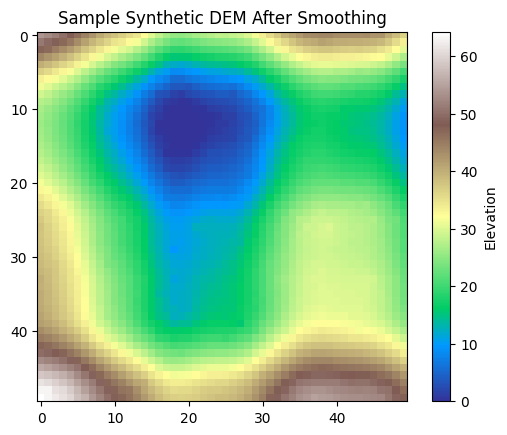

In [6]:
# Example usage
dem_simulator = DEMSimulator(num_dems=3, 
                             size=60, 
                             hilliness_range=(10, 500), 
                             total_iterations=33, 
                             river_freq=3)
dem_simulator.generate_all_dems()
dems = dem_simulator.get_dems()

# Visualize one of the DEMs
import matplotlib.pyplot as plt
plt.imshow(dems[0], cmap='terrain')
plt.colorbar(label='Elevation')
plt.title('Sample Synthetic DEM After Smoothing')
plt.show()